# Import

In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import os
import copy
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
import time

plt.rcParams["figure.figsize"] = (12,6)
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=16, size=(3, 224, 224)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    #image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Create DataLoaders

In [2]:
def find_classes(fulldir):
    classes = os.listdir(fulldir)
    classes.sort()
    class_to_idx = dict(zip(classes, range(len(classes)))) 
    idx_to_class = {v:k for k,v in class_to_idx.items()}
    train = []
    
    for i, label in idx_to_class.items():
        path = fulldir+"/"+label
        for file in os.listdir(path):
            train.append([f'{label}/{file}', label, i])
    df = pd.DataFrame(train, columns=["file", "class", "class_index"]) 
    return classes, class_to_idx, idx_to_class, df

root_dir = "/kaggle/input/neu-plantseedlingsclassificationdl/Nonsegmented_pack - k/train"
classes, class_to_idx, idx_to_class, df = find_classes(root_dir)
num_classes = len(classes)

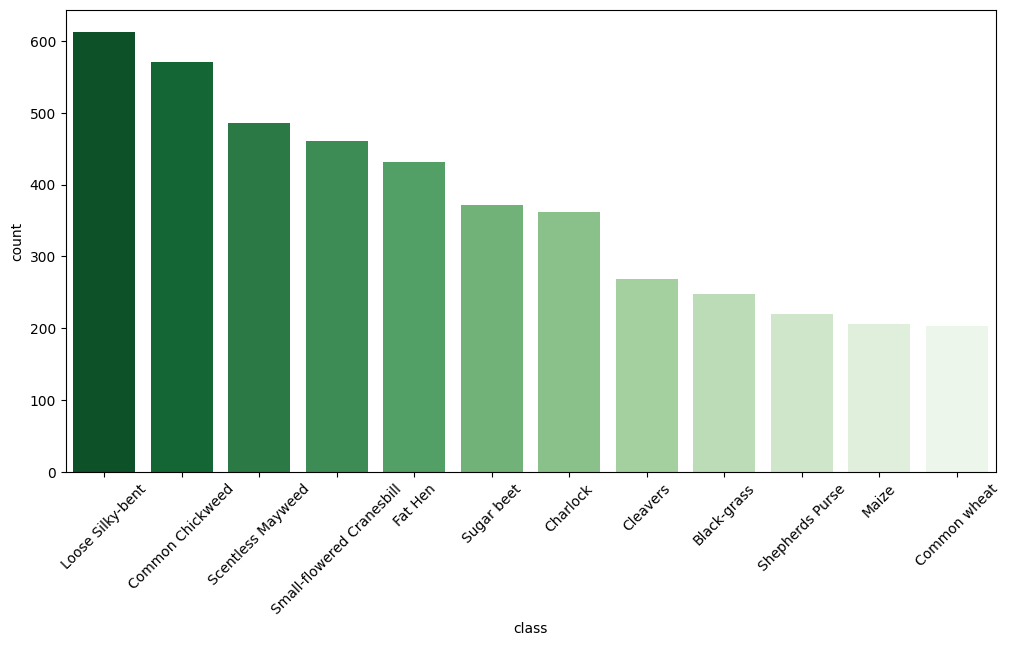

In [3]:
g = sns.countplot(data = df ,x = "class", order = df['class'].value_counts().index, palette='Greens_r')
plt.xticks(rotation=45);

In [4]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.transform = transform
        self.df = dataframe
        self.root_dir = root_dir
        #self.classes = 
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        fullpath = os.path.join(self.root_dir, self.df.iloc[idx][0])
        image = Image.open(fullpath).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.df.iloc[idx][2]

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees = 0, translate = (0.3, 0.3)),
    #transforms.CenterCrop(384),
    transforms.Resize((324,324)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    #transforms.CenterCrop(384),
    transforms.Resize((324, 324)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
X_train, X_val = train_test_split(df,test_size=0.2, random_state=42,stratify=df['class_index'])

In [7]:
train_dataset = PlantDataset(X_train,root_dir, train_transform)
val_dataset = PlantDataset(X_val,root_dir, val_transform)

In [8]:
batch_size =64
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers= num_workers,shuffle=True, drop_last=True , pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers= num_workers, drop_last=True , pin_memory = True)

In [9]:
# img, label = next(iter(train_loader))
# show_tensor_images(img, num_images=16, size=(3, 324, 324))

# Train Model

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, device = device):
    #since = time.time()
    model.to(device)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0 
    
    for epoch in range(num_epochs):        
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
                train_loss =0.0 
                train_acc = 0
                
                for image,label in train_loader:
                    image = image.to(device)
                    label = label.to(device)
                    
                    #forward
                    y_pred = model(image)
                    #loss
                    loss = criterion(y_pred, label)
                    
                    train_loss+=loss.item()
                    #optimizer zero grad
                    optimizer.zero_grad()
                    
                    #loss backward
                    loss.backward()
                    
                    #update 
                    optimizer.step()
                    
                    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                    train_acc += (y_pred_class == label).sum().item()/len(y_pred)
                
                scheduler.step()
                train_loss/=len(train_loader)
                train_acc/=len(train_loader)
                
            else:
                model.eval()
                test_loss, test_acc = 0, 0
                with torch.inference_mode():
                    for image, label in val_loader:
                        image = image.to(device)
                        label = label.to(device)
                        
                        test_pred_logits = model(image)
                        
                        loss = criterion(test_pred_logits, label)
                        test_loss += loss.item()
                        
                        test_pred_labels = test_pred_logits.argmax(dim=1)
                        test_acc += ((test_pred_labels == label).sum().item()/len(test_pred_labels))
                test_loss = test_loss / len(val_loader)
                test_acc = test_acc / len(val_loader)
                
                if test_acc > best_acc:
                    best_acc = test_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  6%|▌         | 5.98M/97.8M [00:00<00:01, 62.7MB/s]

 32%|███▏      | 31.4M/97.8M [00:00<00:00, 183MB/s] 

 60%|██████    | 59.1M/97.8M [00:00<00:00, 232MB/s]

 91%|█████████ | 88.6M/97.8M [00:00<00:00, 262MB/s]

100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s]

In [13]:
c=0
for child in model.children():
    c+=1
    if c<8:
        for param in child.parameters():
            param.requires_grad = False
num_ftrs = model.fc.in_features

model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

In [14]:
model_ft = train_model(model, criterion, optimizer,exp_lr_scheduler,num_epochs=50)

Epoch: 1 | train_loss: 1.1183 | train_acc: 0.6395 | test_loss: 1.6012 | test_acc: 0.7572


Epoch: 2 | train_loss: 0.3984 | train_acc: 0.8696 | test_loss: 0.3129 | test_acc: 0.9026


Epoch: 3 | train_loss: 0.3004 | train_acc: 0.9031 | test_loss: 0.2630 | test_acc: 0.9219


Epoch: 4 | train_loss: 0.2656 | train_acc: 0.9148 | test_loss: 0.2597 | test_acc: 0.9135


Epoch: 5 | train_loss: 0.2340 | train_acc: 0.9259 | test_loss: 0.2206 | test_acc: 0.9291


Epoch: 6 | train_loss: 0.1998 | train_acc: 0.9344 | test_loss: 0.1798 | test_acc: 0.9327


Epoch: 7 | train_loss: 0.1644 | train_acc: 0.9415 | test_loss: 0.1624 | test_acc: 0.9495


Epoch: 8 | train_loss: 0.1817 | train_acc: 0.9395 | test_loss: 0.1754 | test_acc: 0.9363


Epoch: 9 | train_loss: 0.1397 | train_acc: 0.9526 | test_loss: 0.1463 | test_acc: 0.9531


In [ ]:
torch.save(model_ft, "best_model.pt")

# Testing

In [ ]:
class TestPlant(Dataset):
    def __init__(self, rootdir, transform=None):
        self.transform=transform
        self.rootdir=rootdir
        self.image_files = os.listdir(self.rootdir)
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        fullpath = os.path.join(self.rootdir, self.image_files[idx])
        image = Image.open(fullpath).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [ ]:
test_dataset = TestPlant(rootdir="/kaggle/input/neu-plantseedlingsclassificationdl/Nonsegmented_pack - k/test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers= num_workers, shuffle=False)

In [ ]:
# img, file_names = next(iter(test_loader))
# show_tensor_images(img, num_images=16, size=(3, 324, 324))

In [ ]:
test_filenames = os.listdir("/kaggle/input/neu-plantseedlingsclassificationdl/Nonsegmented_pack - k/test")
submission = pd.DataFrame(test_filenames, columns=["file"])
submission["species"] = ""
submission.head()

In [ ]:
def test(submission, test_loader, model, device=device):
    model.to(device)
    with torch.no_grad():
        for image, file_names in test_loader:
            image = image.to(device)
            y_pred = model(image)
            y_pred_labels = y_pred.argmax(dim=1)
            y_pred_labels = y_pred_labels.cpu().numpy()
        
            submission.loc[submission["file"].isin(file_names), "species"] = y_pred_labels

In [ ]:
model = torch.load("/kaggle/working/best_model.pt")
model.eval()
test(submission, test_loader, model)

In [ ]:
submission.head(20)

In [ ]:
submission = submission.replace({"species": idx_to_class})

In [ ]:
submission.to_csv("/kaggle/working/submission.csv", index=False)

# References
1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
2. https://www.learnpytorch.io/06_pytorch_transfer_learning/#4-train-model